In [64]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, t, anderson, skewnorm, skewtest

In [2]:
prices = yf.download('SPY', start='2022-1-1')['Adj Close']

[*********************100%***********************]  1 of 1 completed


In [56]:
returns = prices.pct_change().dropna()
returns.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 373 entries, 2022-01-04 to 2023-06-29
Series name: Adj Close
Non-Null Count  Dtype  
--------------  -----  
373 non-null    float64
dtypes: float64(1)
memory usage: 5.8 KB


<Axes: xlabel='Date'>

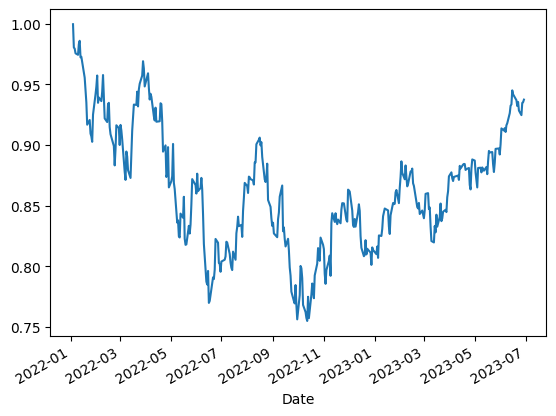

In [6]:
np.cumprod(1 + returns).plot()

In [36]:
# Calculate VaR95
VaR95 = np.percentile(returns, 5)
print('VaR(95): ', str(VaR95))

VaR(95):  -0.021077953763268462


In [37]:
# CVaR95 calculated from return data
CVaR95 = returns[returns <= VaR95].mean()
print('VaR(95): ', str(CVaR95))

VaR(95):  -0.03036776373810742


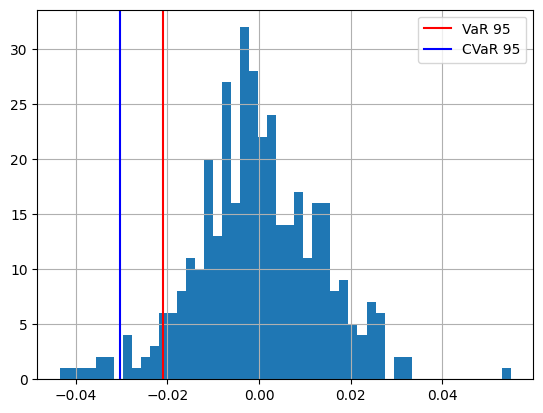

In [24]:
#Plot returns as a histogram
returns.hist(bins=50)
plt.axvline(x=VaR95, color='r', linestyle='-', label="VaR 95")
plt.axvline(x=CVaR95, color='b', linestyle='-', label="CVaR 95")
plt.legend()
plt.show()

In [8]:
# sort returns to generate a list (sorted returns a list)
sort_returns = sorted(returns)

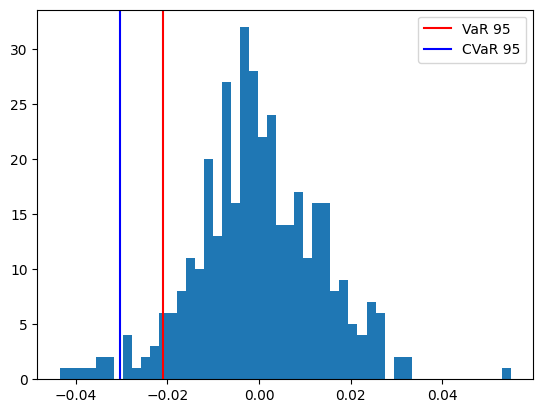

In [35]:
# Have to use plt.hist() with a list
plt.hist(sort_returns, bins=50)
plt.axvline(x=VaR95, color='r', linestyle='-', label="VaR 95")
plt.axvline(x=CVaR95, color='b', linestyle='-', label="CVaR 95")
plt.legend()
plt.show()

In [10]:
# Calculate values for parametric VaR
mu = returns.mean()
sigma = returns.std()
confidence_level = 0.05

# ppf = probability point function
var_95 = norm.ppf(confidence_level, mu, sigma)
print('VaR(95): ', str(var_95))

VaR(95):  -0.022431939040567825


In [32]:
# Calculate CVaR using parametric data *****not sure about this, should be negative (?)****
tail_loss = norm.expect(lambda x: x, loc = mu, scale = sigma, ub = var_95)
cvar_95 = (1 / (1 - 0.95)) * tail_loss
print('CVaR(95): ', str(cvar_95))

CVaR(95):  -0.028110005520712883


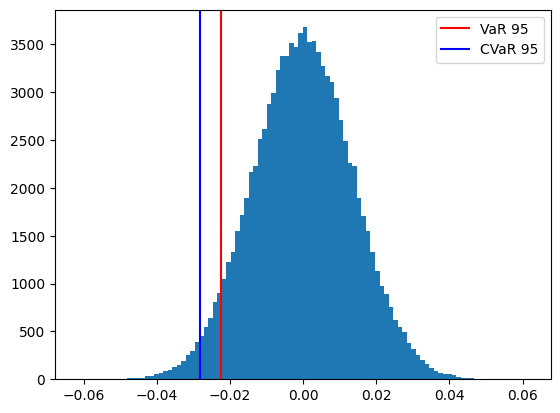

In [33]:
# Plot VaR and CVar calculated from normal distribution
plt.hist(norm.rvs(size = 100000, loc = mu, scale = sigma), bins = 100)
plt.axvline(x = var_95, c='r', label = "VaR 95")
plt.axvline(x = cvar_95, c='b', label = "CVaR 95")
plt.legend()
plt.show()

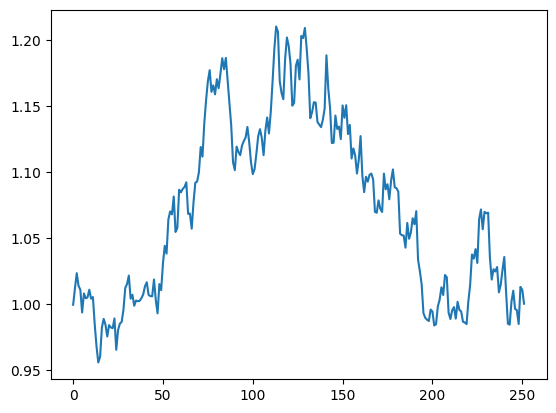

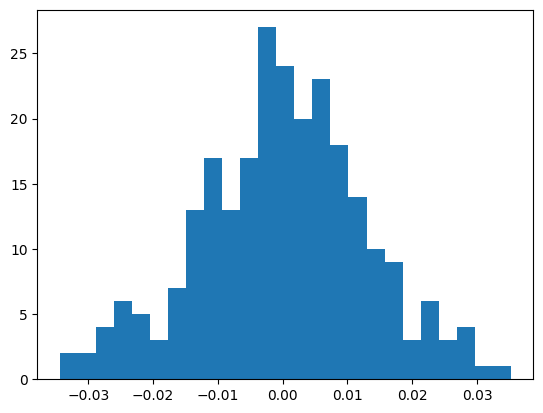

In [38]:
# Generate a single simulation of random returns
T = 252

# Random returns
rand_rets = np.random.normal(mu, sigma, T)

# Forecasted random walk
forecasted_returns = np.cumprod(1 + rand_rets)

# Plot the random walk
plt.plot(range(T), forecasted_returns)
plt.show()
plt.close()

plt.hist(rand_rets, bins=25)
plt.show()

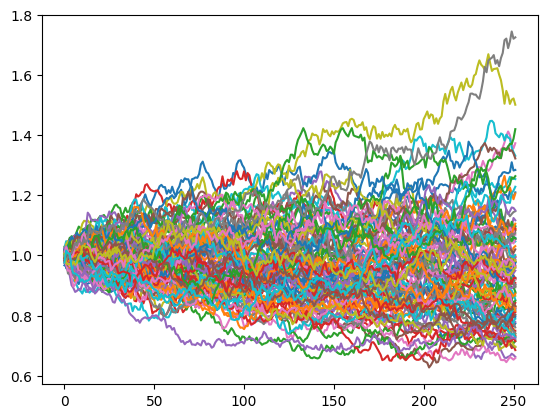

In [39]:
# Monte Carlo simulation
# Loop through 100 simulations
for i in range(0, 100):

    # Generate the random returns
    rand_rets2 = np.random.normal(mu, sigma, T)
    
    # Create the Monte carlo path
    forecasted_returns2 = np.cumprod(1 + rand_rets2)
    
    # Plot the Monte Carlo path
    plt.plot(range(T), forecasted_returns2)

# Show the simulations
plt.show()

In [50]:
# Aggregate the returns
sim_returns = []

# Loop through 100 simulations
for i in range(100):

    # Generate the Random Walk
    rand_rets3 = np.random.normal(mu, sigma, T)
    
    # Save the results
    sim_returns.append(rand_rets3)

# Calculate the VaR(95)
var_95_mc = np.percentile(sim_returns, 5)
print('VaR(95): ', str(var_95_mc))

VaR(95):  -0.02217402690738631


In [51]:
# Example of np.percentile with multiple objects

a = np.array([[10, 7, 4], [3, 2, 1]])

print(a)


print(np.percentile(a, 50))


print(np.percentile(a, 50, axis=0))


print(np.percentile(a, 50, axis=1))

b = np.array([10, 7, 4, 3, 2, 1])

print(np.percentile(b, 50))

[[10  7  4]
 [ 3  2  1]]
3.5
[6.5 4.5 2.5]
[7. 2.]
3.5


In [ ]:
# Fitting data to distributions

In [54]:
# Compare to mu and sigma from before
print(mu)
print(sigma)

-8.089668339837641e-05
0.013588468901390493


In [59]:
# Fit data to a normal distribution
params_norm = norm.fit(returns)
params_norm

(-8.089668339837641e-05, 0.013570241570715848)

In [63]:
# Anderson-Darling test
# null hypothesis = data are normally distibuted
# test statistic rejects Normal distribution is larger than the critical values
anderson(returns)

AndersonResult(statistic=0.8147024370244935, critical_values=array([0.57 , 0.649, 0.779, 0.908, 1.081]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=-8.089668339837641e-05, scale=0.013588468901390493)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')

In [62]:
var_95_norm = norm.ppf(confidence_level, *params_norm)
print('VaR(95): ', str(var_95_norm))

VaR(95):  -0.02240195774959799


In [60]:
# Fit returns to Student's t distribution
params_t = t.fit(returns)
params_t

(10.318764371140675, -6.116512722157975e-05, 0.012199601626845712)

In [61]:
var_95_t = t.ppf(confidence_level, *params_t)
print('VaR(95): ', str(var_95_t))

VaR(95):  -0.022103360073564417


In [65]:
# Skewnorm distribution
skewtest(returns)

SkewtestResult(statistic=-0.2151957664257301, pvalue=0.8296146915133749)

In [66]:
params_skewnorm = skewnorm.fit(returns)
params_skewnorm

(-0.7007115107069279, 0.006903828510896893, 0.015262308879925659)

In [68]:
var_95_skewnorm = skewnorm.ppf(confidence_level, *params_skewnorm)
print('VaR(95): ', str(var_95_skewnorm))

VaR(95):  -0.02262637138094263
